In [2]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# Forecasting

In [3]:
df = pd.read_csv("forecasting_data.csv")
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


## 1. Visualize and interprete the pattern of this time-series

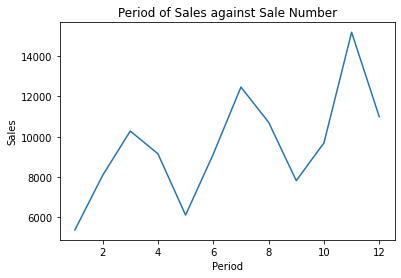

In [4]:
plt.plot(df["Period"], df["Sales"])
plt.title("Period of Sales against Sale Number")
plt.xlabel("Period")
plt.ylabel("Sales")
plt.show()

There is an evident spike every 2 periods starting from 1, alternating between maximum and minimum spikes.  

## 2. Predict future demand in the four next quarters without seasonality

### Using moving average

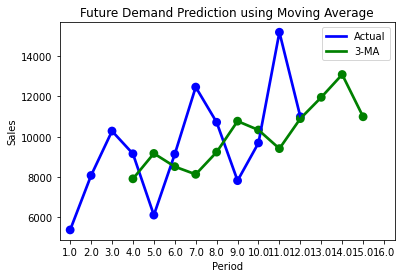

In [5]:
#moving average function
def moving_average(df, k, to_period):
    #definme new data frame for period and sales data
    moving_average_df = pd.DataFrame(columns=['Period','Sales'])
    for i in range(to_period):
        if i >= k:
            #future period prediction
            past = df["Sales"][i-k:i]
            predict = past.mean()
        else:
            #period data exists
            predict = None
        moving_average_df.loc[i] = [i + 1, predict]
    return moving_average_df

#plot prediction
f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
ax.set_title("Future Demand Prediction using Moving Average")
plt.show()

### Using exponential smoothing

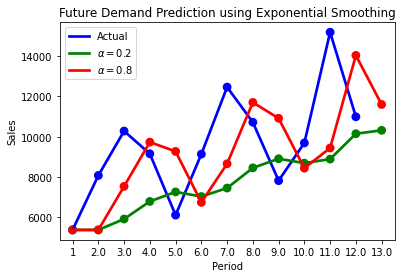

In [6]:
#exponential smoothing function
def exponential_smoothing(df, alpha):
    #define new dataframe for period and sales
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df.loc[0] = [1, df["Sales"][0]]
    
    for i in range(len(df)):
        #prediction formula
        predict = (alpha * df["Sales"][i]) + ((1 - alpha) * es_df["Sales"][i])
        es_df.loc[i+1] = [i+2, predict]
    return es_df

#plot prediction
f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
ax.set_title("Future Demand Prediction using Exponential Smoothing")
plt.show()

Evidently, alpha of 0.8 is closer to the actual future demand prediction than 0.2. This indicates this parameter value is of higher accuracy and reliability. 

## 3. Predict future demand in the four next quarters with seasonality

c:\Users\61406\AppData\Local\Programs\Python\Python36-32\lib\site-packages\ipykernel_launcher.py:42: RankWarning: Polyfit may be poorly conditioned


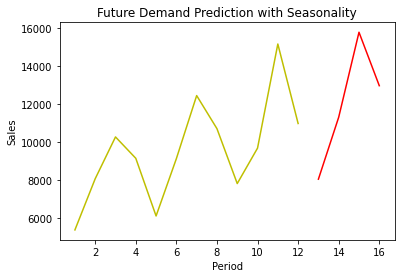

In [7]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'

def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)
    
    season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)
    
    avg_df = season_df.apply(np.mean)
    
    seasonal_index_df = pd.DataFrame(columns=['I','II','III'])
    seasonal_index_df['I'] = season_df["I"] / avg_df["I"]
    seasonal_index_df['II'] = season_df["II"] / avg_df["II"]
    seasonal_index_df['III'] = season_df["III"] / avg_df["III"]
    seasonal_index_df['Avg'] = seasonal_index_df.mean(axis = 1)
    
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)
    
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    forecast_df['Sales'] = seasonal_index_df["Avg"] * average_predict
    forecast_df['Period'] = months
    forecast_df.index = np.array(months) - 1
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.title("Future Demand Prediction with Seasonality")
plt.xlabel("Period")
plt.ylabel("Sales")
plt.show()

# 4.Evaluation: compare the above implemented methods

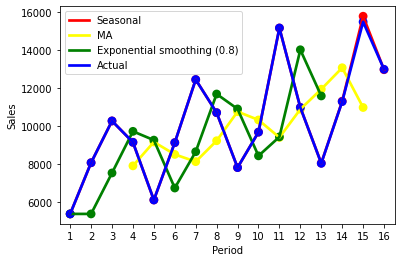

In [8]:
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)

#plot each prediction method
f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing (0.8)", "Actual"])
plt.show()

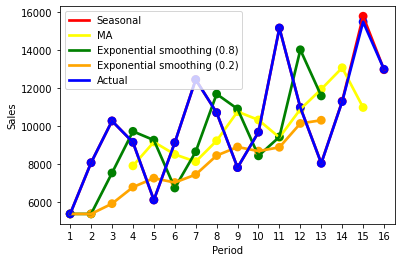

In [16]:
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)

#plot ALL prediction method - including 0.2 alpha
f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='orange')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing (0.8)", "Exponential smoothing (0.2)", "Actual"])
plt.show()

In [10]:
ma_eval = moving_average(eval_df, 3, 16)
es_eval_02 = exponential_smoothing(eval_df, 0.2)
es_eval_08 = exponential_smoothing(eval_df, 0.8)

MAD = np.absolute(eval_df["Sales"][12:16] - ma_eval["Sales"][12:16])
MAD = MAD.mean()
print("MAD of {0}: {1}".format("3-MA", MAD))

MAD = np.absolute(eval_df["Sales"][12:16] - es_eval_02["Sales"][12:16])
MAD = MAD.mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))

MAD = np.absolute(eval_df["Sales"][12:16] - es_eval_08["Sales"][12:16])
MAD = MAD.mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))

MAD = np.absolute(eval_df["Sales"][12:16] - season_df["Sales"][0:4])
MAD = MAD.mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

MAD of 3-MA: 2694.75
MAD of Exponential smoothing with alpha=0.2: 2707.7580143305513
MAD of Exponential smoothing with alpha=0.8: 3088.7232615120074
MAD of Seasonality Method: 85.88221407247033


In [11]:
MSE = (eval_df["Sales"][12:16] - ma_eval["Sales"][12:16]) ** 2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("3-MA", MSE))

MSE = (eval_df["Sales"][12:16] - es_eval_02["Sales"][12:16]) ** 2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))

MSE = (eval_df["Sales"][12:16] - es_eval_08["Sales"][12:16]) ** 2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))

MSE = (eval_df["Sales"][12:16] - season_df["Sales"][0:4]) ** 2
MSE= MSE.mean()
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

MSE of 3-MA: 11544241.36111111
MSE of Exponential smoothing with alpha=0.2: 9744054.271861337
MSE of Exponential smoothing with alpha=0.8: 10909182.694821384
MSE of Seasonality Method: 22206.089646322016


The methods of moving average, exponential smoothing (alpha = 0.8 and alpha = 0.2), and seasonanility were used to predict the future demand of sales fo months 13, 14, 15, 16. Mean absolute deivation (MAD) and mean squared error (MSE) were used to evaluate each prediction method. MAD Inidcates the average magnitude of errors in the set of prediction, without considering if error was higher or lower. MSE measures the errors before averaging, higlighting larger errors when squared. These are used to identify the accuracy of each method compared to the actual data, where a lower vvalue suggests better forecasting accuracy. 

Evidently, the lowest MAD value measured was the seasonality method with 85.88. The next lowest was moving average, with a value of 2694.75. Evidently, the seasonality method is significantly more accuracy than the others. This is evident in the comparison graph as it almost directly follows the actual trend. The lowest MSE value was also seasonality with 22206.09. This was significantly low compared to the others, signifying its accuracy. This is justified as predictions with seasonality considers seasonal patterns in data, identifying trends within specific quarters, and adjusting future forcasts based on seasonal effects. This caused a higher measure of prediction.

The simple methods of prediction, such as moving average, does not consider enough complex patterns or trends such as the seasonality method causing a lack in accuracy. This is similar for exponential smoothing, as it is slightly more complex and adjusts better to recent trends, it struggles to identify specific patterns. Seasonality is the best method for this dataset for future demand prediction. 